<br/>

$$ \huge{\underline{\textbf{ Model Free Control - Off Policy }}} $$

$$ \Large{\textbf{ Part 3: Importance Sampling Methods }} $$


$$ \color{red}{\textbf{ WORK IN PROGRESS }} $$


# Contents

* Intro
  * [Sources](#Sources)
  * [Introduction](#Introduction)
  * [Imports](#1D-Corridor) - import stuff from [part 1](../Lecture05/ModelFreeControl_Part1.html)
  * [SARSA - Refresher](#SARSA---Refresher) - refresher from [part 1](../Lecture05/ModelFreeControl_Part1.html#SARSA)

* Importance Sampling Methods
  * [SARSA + Importance Sampling](#SARSA-+-Importance-Sampling) - off-policy SARSA using importance sampling (and n-step extensions, aka tree backup)
  * [Off-Policy MC Control]()

# Sources

* UCL Course on RL: http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html
  * Lecture 5 pdf: http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/control.pdf
  * Lecture 5 vid: https://www.youtube.com/watch?v=0g4j2k_Ggc4
* Sutton and Barto 2018: http://incompleteideas.net/book/the-book-2nd.html

# Introduction

Same as [previous part](../Lecture05_Ctrl/ModelFreeControl_Part2.html), this post roughly corresponds to part 2 of Lecture 5 of UCL RL course by David Silver.

We will explore off-policy algorithms based on importance sampling, specifically SARSA with Importance Sampling (1-step) and n-step extension. Off-Policy Monte-Carlo is just N-Step SARSA with Importance Sampling with number of steps set higher than longest possible episode (+inf).

Let's have a look at algorithm zoo

<img src="assets/alg_zoo.png"/>
<center>Table: Numbers in bracket refer to chapters in Sutton and Barto 2018</center>
<center>Implementations in this notebook do not exactly correspond to the book</center>

<br/>

And let's bring back mini-MDP. Mini-MDP is described properly in [previous part](../Lecture05_Ctrl/ModelFreeControl_Part2.html)

# Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Environment is exactly the same as in [part 1](ModelFreeControl_Part1.html)
<img src="assets/corridor2.png"/>

In [4]:
from ModelFreeControl_Part1 import LinearEnv, REF_RANDOM, REF_GREEDY

Let's create environment and policies for future use

In [5]:
env = LinearEnv()

pi_random = np.tile([0.50, 0.50], [11, 1])  # starting random policy
pi_greedy = np.tile([0.00, 1.00], [11, 1])  # optimal greedy policy
pi_skewed = np.tile([0.40, 0.60], [11, 1])  # will use this later

And import common functions, they are also exactly the same as in [part 1](ModelFreeControl_Part1.html)

In [6]:
from ModelFreeControl_Part1 import generate_episode, LogEntry, plot_experiments

# TD(0) with Importance Sampling

In [14]:
def is_td0_experiment(env, pol_beh, pol_tar, N, alpha):
    hist, perf = [], []
    Q = np.zeros(shape=[env.nb_st, env.nb_act])
    for ep in range(N):
        trajectory = generate_episode(env, pol_beh)
        trajectory_2 = generate_episode(env, pol_tar)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            St_1, Rt_1, _, At_1 = trajectory[t+1]
            target = (pol_tar[St, At] / pol_beh[St, At]) * Q[St_1, At_1]
            Q[St, At] = Q[St, At] + alpha * (Rt_1 + 1.0*target - Q[St, At])
        hist.append(Q.copy())
        perf.append(len(trajectory_2)-1)
    return np.array(hist), np.array(perf)

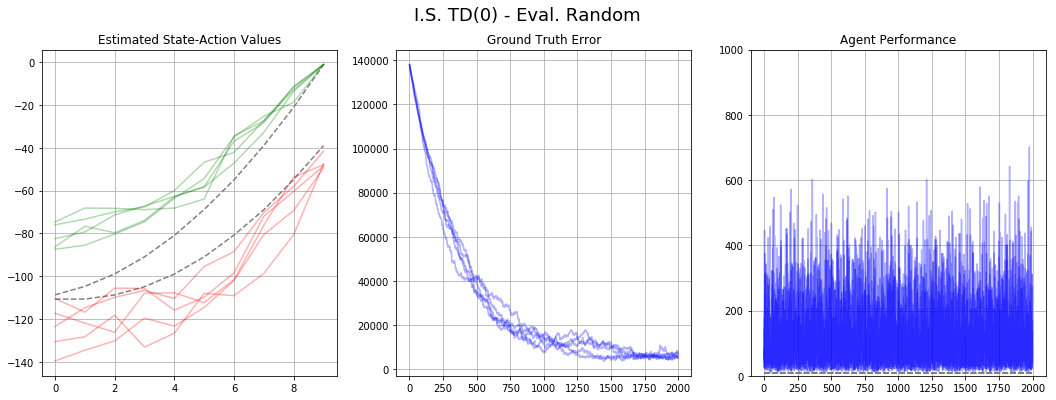

In [16]:
log = []
for _ in range(5):
    hist, perf = is_td0_experiment(env, pol_beh=pi_skewed, pol_tar=pi_random, N=2000, alpha=0.05)
    log.append(LogEntry('is-td', hist, perf))
plot_experiments(log, REF_RANDOM, 'I.S. TD(0) - Eval. Random')

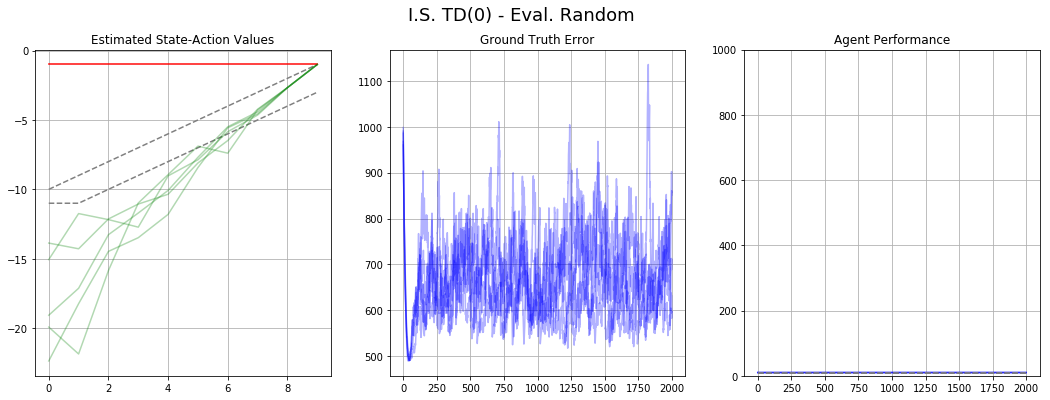

In [17]:
log = []
for _ in range(5):
    hist, perf = is_td0_experiment(env, pol_beh=pi_skewed, pol_tar=pi_greedy, N=2000, alpha=0.05)
    log.append(LogEntry('is-td', hist, perf))
plot_experiments(log, REF_GREEDY, 'I.S. TD(0) - Eval. Greedy')